# Vaccines and patient characteristics

## Import libraries and data

The datasets used for this report are created using the study definition [`/analysis/study_definition.py`](../analysis/study_definition.py), using codelists referenced in [`/codelists/codelists.txt`](../codelists/codelists.txt). 

In [1]:
%load_ext autoreload
%autoreload 2

import pyodbc
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date
import os
import glob
import subprocess
from ebmdatalab import charts
from IPython.display import display, Markdown, HTML
#from lib.functions import *

# get current branch
current_branch = subprocess.run(["git", "rev-parse", "--abbrev-ref", "HEAD"], capture_output=True).stdout.decode("utf8").strip()

In [2]:
# import data, carry out basic joins for lookups and create flags.

# import data and fill nulls with 0
df = pd.read_csv(os.path.join("..","output", "input_delivery.csv")).fillna(0)

# ensure that no patients are included outside the desired criteria
# df = df.loc[(df["care_home_type"].isin(["PS","PN","PC"])) | (df["ageband"].isin(["70-79","80+"]) | (df["covid_vacc_date"]!=0)]
 
# convert ethnic categories to words
eth_16 = pd.read_csv(os.path.join("..","analysis", "ethnicity_16_lookup.csv"))
df = df.merge(eth_16, how="left", left_on="ethnicity_16", right_on="code").rename(columns={"name":"Ethnicity_sixteen_categories"})

ethnicity_6_lookup = {0:"Unknown", 1:"White", 2:"Mixed", 3:"South Asian", 4:"Black", 5:"Other"}
df["Ethnicity_broad_categories"] = [ethnicity_6_lookup[x] for x in df['ethnicity'].fillna(0).astype(int)]

# describe imd partially in words
imd_lookup = {0:"Unknown", 1:"1 Most deprived", 2:"2", 3:"3", 4:"4", 5:"5 Least deprived"}

# replace flags with descriptive terms
df = df.assign(
    covid_vacc_flag = np.where(df["covid_vacc_date"]!=0,"vaccinated","unvaccinated"),
    covid_vacc_flag_ox = np.where(df["covid_vacc_oxford_date"]!=0, 1, 0),
    covid_vacc_flag_pfz = np.where(df["covid_vacc_pfizer_date"]!=0, 1, 0),
    covid_vacc_2nd = np.where(df["covid_vacc_second_dose_date"]!=0, 1, 0),
    covid_vacc_bin = np.where(df["covid_vacc_date"]!=0, 1, 0),
    ##care_home = np.where(df["care_home_type"].isin(["PS","PN","PC"]), "care home", "other residences"),
    ssri = np.where((df["ssri"]==1) & (df["psychosis_schiz_bipolar"]==0) &\
                    (df["intel_dis_incl_downs_syndrome"]==0) & (df["dementia"]==0), 1, 0),
    Ethnicity_broad_categories = df['Ethnicity_broad_categories'].fillna("Unknown"),
    Ethnicity_sixteen_categories = df['Ethnicity_sixteen_categories'].fillna("Unknown"),
    region = df['region'].replace(0, "Unknown"),
    stp = df['stp'].replace(0, "Unknown"),
    sex = df['sex'].replace(['I','U'], "Other/Unknown"),
    bmi = np.where((df["bmi"]=="Not obese"), "under 30", "30+"),
    Index_of_Multiple_Deprivation = [imd_lookup[x] for x in df['imd'].fillna(0).astype(int)]
    )\
    .drop(["imd","code","ethnicity_16", "ethnicity", "adrenaline_pen", "has_died", "has_follow_up"],1)

# care homes: regroup age bands (to later keep only 65+ labelled as care home residents)
df.loc[(df["care_home_type"].isin(["PS","PN","PC"])) & (df["age"]>=65) & (df["age"]<70), "ageband"] = "65-69"
# amend community age band to remove any care home flags for under 65s 
    #(only elderly care homes are included so these are likely live-in staff+their families or other non-care recipients)
df.loc[(df["ageband_community"]=="care home") & (df["age"]<65), "ageband_community"] = df["ageband"]
    
for c in ["care_home","dementia", 
          "chronic_cardiac_disease", "current_copd", "dialysis", "dmards","psychosis_schiz_bipolar",
         "solid_organ_transplantation", "chemo_or_radio", "intel_dis_incl_downs_syndrome","ssri",
          "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer", "bone_marrow_transplant",
          "cystic_fibrosis", "sickle_cell_disease", "permanant_immunosuppression",
          "temporary_immunosuppression", "asplenia"]:
    df[c] = np.where(df[c]==1, "yes", "no")
   
df = df.rename(columns={"imd":"Index_of_Multiple_Deprivation", "ageband_community":"community_ageband"})
# get total population sizes and names for each STP
stps = pd.read_csv(os.path.join("..","lib","stp_dict.csv"), usecols=["stp_id","name","list_size_o80"])
df = df.merge(stps, left_on="stp", right_on="stp_id", how="left").drop(["care_home_type","age","stp_id"], 1).rename(columns={"name":"stp_name"})  
    

/root/.pyenv/versions/3.8.1/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (42) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Find latest date of covid vaccinations covered in the dataset   

latest_date = df[df["covid_vacc_date"]!=0]["covid_vacc_date"].max()
latest_date_fmt = datetime.strptime(latest_date, "%Y-%m-%d").strftime("%d %b %Y")
print("latest date ", latest_date_fmt)


latest date  13 Jan 2021


## Process data - summarise by group and demographics at latest date

#### Calculate cumulative sums at each date and select latest date + previous figures for comparison

In [5]:
# population subgroups - in a dict to indicate which field to filter on
pops = {"80+":"community_ageband",
        "70-79":"community_ageband", 
        "care home":"community_ageband", 
        "presumed healthcare workers (under 70, non-care home residents)":"other"
        }
groups = pops.keys()

def cumsums(df, groups):
    '''
    Calculate cumulative sums
    
    Inputs:
    df (dataframe): input data
    groups(list): subgroups to breakdown by
    
    out: 
    out2(dataframe)
    '''
    df_dict_out = {}
    for k in groups:
        # filter dataframe to eligible group
        if pops[k]=="other": # for "all others" filter out the defined groups above
            out = df.copy().loc[(~df["community_ageband"].isin(["care home","70-79","80+"]))]
            cols = ["sex","ageband", "Ethnicity_broad_categories", "Ethnicity_sixteen_categories","Index_of_Multiple_Deprivation",
                    "bmi","chronic_cardiac_disease", "current_copd", "dialysis", "dmards","ssri"]
        elif k=="care home": 
            out = df.copy().loc[(df[pops[k]]==k)]
            cols = ["sex", "ageband", "Ethnicity_broad_categories"]
        else:    # age groups
            out = df.copy().loc[(df[pops[k]]==k)]
            cols = ["sex","Ethnicity_broad_categories","Ethnicity_sixteen_categories", "Index_of_Multiple_Deprivation", 
                    "bmi", "chronic_cardiac_disease", "current_copd", "dialysis", "dmards", "dementia",
                    "psychosis_schiz_bipolar","intel_dis_incl_downs_syndrome","ssri",
                     "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"]
            
        df_dict_temp = {}
        
        # overall figures
        total = out[["patient_id"]].nunique()[0]
        out2 = out.copy().loc[(out["covid_vacc_flag"]=="vaccinated")]
        # group by date of covid vaccines to calculate cumulative sum of vaccines at each date of the campaign
        out2 = pd.DataFrame(out2.groupby(["covid_vacc_date"])[["patient_id"]].nunique().unstack().fillna(0).cumsum()).reset_index()
        out2 = out2.rename(columns={0:"overall"}).drop(["level_0"],1)

        # in case no vaccinations on latest date for some STPs/groups, insert the latest data as a new row with the required date:
        if out2["covid_vacc_date"].max()<latest_date:
            out2.loc[max(out2.index)+1] = [latest_date, out2["overall"].max()]

        # suppress low numbers
        out2["overall"] = out2["overall"].replace([1,2,3,4,5,6], 0).fillna(0).astype(int)
        out2["overall_total"] = total.astype(int)
        
        out2["overall_percent"] = 100*(out2["overall"]/out2["overall_total"])
        df_dict_temp["overall"] = out2.set_index("covid_vacc_date")
        
        # figures by demographic/clinical features
        for c in cols:
            
            if c=="sex":
                out = out.loc[out[c].isin(["M","F"])]

            # find total number of patients in each subgroup (e.g. no of males and no of females)
            totals = out.groupby([c])[["patient_id"]].nunique().rename(columns={"patient_id":"total"}).transpose()
            
            # find total number of patients vaccinated in each subgroup (e.g. no of males and no of females),
                # cumulative at each date of the campaign
            out2 = out.copy().loc[(out["covid_vacc_flag"]=="vaccinated")]
            out2 = out2.groupby([c, "covid_vacc_date"])["patient_id"].nunique().unstack(0)
            out2 = out2.fillna(0).cumsum()
            
            # suppress low numbers
            out2 = out2.replace([1,2,3,4,5,6], 0).fillna(0)
            # round other values to nearest 7
            out2 = 7*round(out2/7, 0)

            for c2 in out2.columns:
                out2[f"{c2}_total"] = totals[c2][0].astype(int)
                #calculate percentage
                out2[f"{c2}_percent"] = 100*(out2[c2]/out2[f"{c2}_total"])           
            
            # in case no vaccinations on latest date for some STPs/groups, insert the latest data as a new row with the required date:
            if out2.index.max()<latest_date:
                out2.loc[latest_date] = out2.max()
                
            df_dict_temp[c] = out2
        
        df_dict_out[k] = df_dict_temp

    return df_dict_out
    

df_dict_cum = cumsums(df, groups) 


In [6]:
def report_results(df_dict_cum, group, breakdown=[]):
    '''
    Summarise data at latest date, overall and by demographic/clinical features, and including change from previous week.
    Processes one group (e.g. 80+) at a time so must be run within a loop to cover all required groups. 
    
    Inputs:
    df_dict_cum (dict): dictionary of cumulative sums 
    group (str): e.g. "80+" (one of first level index of df_dict_cum)
    breakdown (list): 
    
    Outputs:
    out3 (Dataframe): summary data
    '''
    
    out = pd.DataFrame()
    out3 = pd.DataFrame()
    
    k=group
    
    if len(breakdown)== 0:
        breakdown = df_dict_cum[k].keys()
    
    for c in breakdown:
        out = df_dict_cum[k][c]

        # calculate changes: select only latest date and 7 days ago:
        latest = pd.to_datetime(out.index).max()
        lastweek = (latest + pd.DateOffset(days=-7)).strftime("%Y-%m-%d")
        lastweek = str(max(lastweek, out.index.min()))

        # filter to required values:

        # for groups with a population denominator, keep the percentage value only
        if k != "presumed healthcare workers (under 70, non-care home residents)":
            out = out.filter(regex='percent').round(1)
            col_str = " (percent)"
        # for groups with no denominator, keep the actual values only
        elif k == "presumed healthcare workers (under 70, non-care home residents)":
            # totals and percent not needed
            out = out.filter(regex='^(?!.*total).*$')
            out = out.filter(regex='^(?!.*percent).*$')
            col_str = ""
        
        # if last week's exact date not present, fill in using latest values prior to required date
        if sum(out.index == lastweek)==0:
            out.loc[lastweek] = out.loc[out.index < lastweek].max()
            
        out = out.loc[[latest_date,lastweek],:].transpose()

        '''# if there is only one non-zero value, round the remaining values to avoid suppressed values being calculated
            for i in out2.index:
                if (out2.loc[i] == 0).astype(int).sum() == 1:  
                    out2.loc[i]=10*(out2.loc[i]/10).round(0)
            display(out2)'''
        
        out["weeklyrate"] = ((out[latest_date] - out[lastweek]).fillna(0)).round(1)
        out["Increase in uptake (%)"] = (100*(out["weeklyrate"]/out[lastweek]).fillna(0)).round(1)
        out["weeks_to_target"] = (90 - out[latest_date])/out["weeklyrate"]

        date_reached=pd.Series(dtype="datetime64[ns]", name="date_reached")

        for i in out.index:
            weeks_to_target = out["weeks_to_target"][i]

            if weeks_to_target <25: # if 6mo+ until expected to reach target, assume too little data to tell
                date_reached[i] = (latest + pd.DateOffset(days=weeks_to_target*7)).strftime('%d-%b')
            else:
                date_reached[i] = "unknown"
        out = out.transpose().append(date_reached).transpose().drop("weeks_to_target",1)
        out = out[[lastweek,"weeklyrate","date_reached","Increase in uptake (%)"]].rename(columns={lastweek: f"vaccinated at {lastweek}{col_str}", "weeklyrate":f"Uptake over last 7d{col_str}", "date_reached":"Date projected to reach 90%"})    
        out.index = out.index.str.replace("_percent","")    
        out = out.reset_index().rename(columns={c:"group", "index":"group"})
        out["category"] = c
        out = out.set_index(["category","group"])


        ##### n, percent and total pop figures for latest date
        out2 = df_dict_cum[k][c].reset_index()
        out2 = out2.loc[out2["covid_vacc_date"]==latest_date].reset_index().set_index("covid_vacc_date").drop(["index"], 1).transpose()
        # split field names e.g. "M_percent" ->"M""percent"
        out2.index = pd.MultiIndex.from_tuples(out2.index.str.split('_').tolist())

        out2 = out2.unstack().reset_index(col_level=1)
        out2.columns = out2.columns.droplevel()
        out2 = out2.rename(columns={"index":"group", np.nan:"vaccinated"})
        out2["percent"] = out2["percent"].round(1)
        out2["category"] = c
        out2 = out2.set_index(["category","group"])

        out2 = out2.join(out)

        out3 = out3.append(out2)   

    if k == "presumed healthcare workers (under 70, non-care home residents)":
        out3 = out3.drop(["percent","total","Date projected to reach 90%"],1)
    else:
        out3 = out3.drop(["Increase in uptake (%)"],1)
    
    return out3

## Cumulative vaccination figures - overall

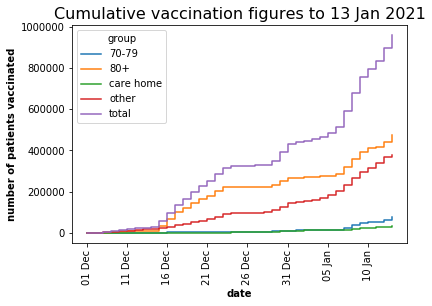

In [7]:
# cumulative chart by day of total vaccines given
dfp = df.copy().loc[(df["covid_vacc_date"]!=0)]
dfp["group"] = np.where(dfp["community_ageband"].isin(["80+","70-79","care home"]), dfp["community_ageband"], "other")
dfp = dfp.groupby(["covid_vacc_date","group"])[["patient_id"]].count()  
dfp = dfp.unstack().fillna(0).cumsum().reset_index().replace([0,1,2,3,4,5],0) 

dfp["covid_vacc_date"] = pd.to_datetime(dfp["covid_vacc_date"]).dt.strftime("%d %b")
dfp = dfp.set_index("covid_vacc_date")
dfp.columns = dfp.columns.droplevel()
dfp["total"] = dfp.sum(axis=1)

dfp.plot(legend=True, ds='steps-post')

plt.xlabel("date", fontweight='bold')
plt.xticks(rotation=90)
plt.ylabel("number of patients vaccinated", fontweight='bold')
plt.title(f"Cumulative vaccination figures to {latest_date_fmt}", fontsize=16)
plt.show()

In [8]:
# summarise data at latest date
groups = ["80+", "70-79", "care home", "presumed healthcare workers (under 70, non-care home residents)"]
df_dict_latest = {}
for g in groups:
    out = report_results(df_dict_cum, g)
    df_dict_latest[g] = out

## Proportion of each eligible population vaccinated to date

In [9]:
display(Markdown(f"### As at {latest_date_fmt}"))

def round7(n):
    '''Round n to nearest 7 and output as integer'''
    return ( int(7*round((n/7),1)) )

vaccinated_total = round7( df.loc[df["covid_vacc_date"]!=0]["patient_id"].nunique() )
display(Markdown(f"**Total** population vaccinated in TPP {vaccinated_total:,d}"))

for k in groups:
    out = df_dict_latest[k]
    vaccinated = round7(out.loc[("overall","overall")]["vaccinated"])
    if k != "presumed healthcare workers (under 70, non-care home residents)":
        percent = out.loc[("overall","overall")]["percent"].round(1)
        total = out.loc[("overall","overall")]["total"].astype(int)
        out_str = f"**{k}** population vaccinated {vaccinated:,} ({percent}% of {total:,})"
    else:
        out_str = f"**{k}** population vaccinated {vaccinated:,}"
    if k=="80+": # store values for later use
        overall_rate_80 = percent

    display(Markdown(out_str))

# count oxford vax as a proportion of total; filter to date of first vax only in case of patients having mixed types    
oxford_vaccines = round7(df.copy().loc[df["covid_vacc_date"]==df["covid_vacc_oxford_date"]]["covid_vacc_flag_ox"].sum())
ox_percent = round(100*oxford_vaccines/vaccinated_total, 1)
second_doses = round7(df["covid_vacc_2nd"].sum())
sd_percent = round(100*second_doses/vaccinated_total, 1)

display(Markdown(f"#### Vaccine type and second doses"),
        Markdown(f"- Of those vaccinated, {second_doses:,} have received a **second dose** ({sd_percent}%)"),
        Markdown(f"- Of those vaccinated, {oxford_vaccines:,} received the **Oxford vaccine** as their first dose ({ox_percent}%)"),
        Markdown(f" "),
        Markdown("figures rounded to nearest 7"))

### As at 13 Jan 2021

**Total** population vaccinated in TPP 961,580

**80+** population vaccinated 476,375 (41.1% of 1,160,062)

**70-79** population vaccinated 74,108 (3.6% of 2,080,656)

**care home** population vaccinated 32,174 (33.2% of 96,997)

**presumed healthcare workers (under 70, non-care home residents)** population vaccinated 378,921

#### Vaccine type and second doses

- Of those vaccinated, 169,472 have received a **second dose** (17.6%)

- Of those vaccinated, 65,055 received the **Oxford vaccine** as their first dose (6.8%)

figures rounded to nearest 7

# Detailed summary of uptake among population groups as at latest date

In [10]:
pd.set_option('display.max_rows',200)

for g in groups:
    display(Markdown(f"## "),
            Markdown(f"## COVID vaccination rollout among **{g}** population up to {latest_date_fmt}"),
            Markdown(f"- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)\n"\
                       f"- Patient counts rounded to the nearest 7"))
    out = df_dict_latest[g]
    # suppress previous week's values if change in vaccinated number is <10
    '''    if g!="presumed healthcare workers (under 70, non-care home residents)":
        out["Uptake over last 7d (percent)"]=np.where(out["Uptake over last 7d (percent)"]*out["total"]>=1000, 
                                                      out["Uptake over last 7d (percent)"],0)
        out["vaccinated at 2020-12-30 (percent)"]=np.where(out["Uptake over last 7d (percent)"]*out["total"]>=1000, 
                                                            out["vaccinated at 2020-12-30 (percent)"],0)'''
    display(out)

## 

## COVID vaccination rollout among **80+** population up to 13 Jan 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                      group                                             
overall                       overall                                476376.0   
sex                           F                                      265076.0   
                              M                                      211295.0   
Ethnicity_broad_categories    Black                                    2121.0   
                              Mixed                                     756.0   
                              Other                                    1498.0   
                              South Asian                              7945.0   
                              Unknown                                129199.0   
                              White                                  334852.0   
Ethnicity_sixteen_categories   African                                  329.0   
                               Bangladeshi or British Bangladeshi       287.0   
                               Caribbean                               1533.0   
                               Chinese                                  497.0   
                               Other                                   1001.0   
                               Other Asian                             1204.0   
                              British or Mixed British               317037.0   
                              Indian or British Indian                 4781.0   
                              Irish                                    3346.0   
                              Other Black                               252.0   
                              Other White                             14462.0   
                              Other mixed                               259.0   
                              Pakistani or British Pakistani           1673.0   
                              Unknown                                129199.0   
                              White + Asian                             168.0   
                              White + Black African                      77.0   
                              White + Black Caribbean                   252.0   
Index_of_Multiple_Deprivation 1 Most deprived                         57393.0   
                              2                                       76223.0   
                              3                                      100996.0   
                              4                                      112749.0   
                              5 Least deprived                       119567.0   
                              Unknown                                  9443.0   
bmi                           30+                                     84000.0   
                              under 30                               392371.0   
chronic_cardiac_disease       no                                     333459.0   
                              yes                                    142912.0   
current_copd                  no                                     424641.0   
                              yes                                     51730.0   
dialysis                      no                                     475482.0   
                              yes                                       889.0   
dmards                        no                                     461223.0   
                              yes                                     15148.0   
dementia                      no                                     470274.0   
                              yes                                      6097.0   
psychosis_schiz_bipolar       no                                     473620.0   
                              yes                                      2751.0   
intel_dis_incl_downs_syndrome no                                     475874.0   
                              yes                                       497.0   
ssri             

## 

## COVID vaccination rollout among **70-79** population up to 13 Jan 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                      group                                             
overall                       overall                                 74108.0   
sex                           F                                       40124.0   
                              M                                       33985.0   
Ethnicity_broad_categories    Black                                     434.0   
                              Mixed                                     196.0   
                              Other                                     399.0   
                              South Asian                              2660.0   
                              Unknown                                 15071.0   
                              White                                   55356.0   
Ethnicity_sixteen_categories   African                                  154.0   
                               Bangladeshi or British Bangladeshi        84.0   
                               Caribbean                                217.0   
                               Chinese                                   98.0   
                               Other                                    294.0   
                               Other Asian                              427.0   
                              British or Mixed British                51709.0   
                              Indian or British Indian                 1519.0   
                              Irish                                     784.0   
                              Other Black                                63.0   
                              Other White                              2856.0   
                              Other mixed                                56.0   
                              Pakistani or British Pakistani            630.0   
                              Unknown                                 15071.0   
                              White + Asian                              42.0   
                              White + Black African                      35.0   
                              White + Black Caribbean                    56.0   
Index_of_Multiple_Deprivation 1 Most deprived                         12397.0   
                              2                                       12852.0   
                              3                                       14637.0   
                              4                                       17710.0   
                              5 Least deprived                        14931.0   
                              Unknown                                  1582.0   
bmi                           30+                                     17927.0   
                              under 30                                56182.0   
chronic_cardiac_disease       no                                      58814.0   
                              yes                                     15295.0   
current_copd                  no                                      65646.0   
                              yes                                      8463.0   
dialysis                      no                                      73927.0   
                              yes                                       182.0   
dmards                        no                                      71281.0   
                              yes                                      2828.0   
dementia                      no                                      73633.0   
                              yes                                       476.0   
psychosis_schiz_bipolar       no                                      73325.0   
                              yes                                       784.0   
intel_dis_incl_downs_syndrome no                                      73829.0   
                              yes                                       280.0   
ssri             

## 

## COVID vaccination rollout among **care home** population up to 13 Jan 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent    total  \
category                   group                                       
overall                    overall         32174.0     33.2  96997.0   
sex                        F               23149.0     33.8  68572.0   
                           M                9023.0     31.7  28424.0   
ageband                    65-69             966.0     28.4   3404.0   
                           70-79            5523.0     31.8  17356.0   
                           80+             25690.0     33.7  76236.0   
Ethnicity_broad_categories Black              98.0     21.0    467.0   
                           Mixed              49.0     24.4    201.0   
                           Other              84.0     25.1    334.0   
                           South Asian       168.0     27.1    621.0   
                           Unknown          7721.0     34.1  22620.0   
                           White           24052.0     33.1  72753.0   

                                       vaccinated at 2021-01-06 (percent)  \
category                   group                                            
overall                    overall                                   12.6   
sex                        F                                         12.8   
                           M                                         12.3   
ageband                    65-69                                     11.3   
                           70-79                                     12.3   
                           80+                                       12.8   
Ethnicity_broad_categories Black                                        3   
                           Mixed                                        7   
                           Other                                     10.5   
                           South Asian                                6.8   
                           Unknown                                   13.5   
                           White                                     12.5   

                                       Uptake over last 7d (percent)  \
category                   group                                       
overall                    overall                              20.6   
sex                        F                                      21   
                           M                                    19.4   
ageband                    65-69                                17.1   
                           70-79                                19.5   
                           80+                                  20.9   
Ethnicity_broad_categories Black                                  18   
                           Mixed                                17.4   
                           Other                                14.6   
                           South Asian                          20.3   
                           Unknown                              20.6   
                           White                                20.6   

                                       Date projected to reach 90%  
category                   group                                    
overall                    overall                          01-Feb  
sex                        F                                31-Jan  
                           M                                03-Feb  
ageband                    65-69                            07-Feb  
                           70-79                            02-Feb  
                           80+                              31-Jan  
Ethnicity_broad_categories Black                            08-Feb  
                           Mixed                            08-Feb  
                           Other                            13-Feb  
                           South Asian                      03-Feb  
                           Unknown                          31-Jan  
                           White              

## 

## COVID vaccination rollout among **presumed healthcare workers (under 70, non-care home residents)** population up to 13 Jan 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                      group                                             
overall                       overall                                378922.0   
sex                           F                                      284669.0   
                              M                                       94248.0   
ageband                       0-19                                     3269.0   
                              20-29                                   46928.0   
                              30-39                                   72156.0   
                              40-49                                   87948.0   
                              50-59                                  111223.0   
                              60-69                                   57393.0   
Ethnicity_broad_categories    Black                                    6468.0   
                              Mixed                                    4249.0   
                              Other                                    7301.0   
                              South Asian                             31276.0   
                              Unknown                                 84658.0   
                              White                                  244965.0   
Ethnicity_sixteen_categories   African                                 4333.0   
                               Bangladeshi or British Bangladeshi      1015.0   
                               Caribbean                                973.0   
                               Chinese                                 1596.0   
                               Other                                   5705.0   
                               Other Asian                             9625.0   
                              British or Mixed British               225085.0   
                              Indian or British Indian                15722.0   
                              Irish                                    2016.0   
                              Other Black                              1162.0   
                              Other White                             17871.0   
                              Other mixed                              1491.0   
                              Pakistani or British Pakistani           4914.0   
                              Unknown                                 84658.0   
                              White + Asian                            1281.0   
                              White + Black African                     819.0   
                              White + Black Caribbean                   658.0   
Index_of_Multiple_Deprivation 1 Most deprived                         58135.0   
                              2                                       69993.0   
                              3                                       79457.0   
                              4                                       81424.0   
                              5 Least deprived                        79891.0   
                              Unknown                                 10017.0   
bmi                           30+                                     82915.0   
                              under 30                               296002.0   
chronic_cardiac_disease       no                                     367941.0   
                              yes                                     10976.0   
current_copd                  no                                     373716.0   
                              yes                                      5201.0   
dialysis                      no                                     378532.0   
                              yes                                       385.0   
dmards                        no                                     370510.0   
                              yes                                      8407.0   
ssri             

# Demographics time trend charts

## COVID vaccination rollout among **80+** population up to 13 Jan 2021

### COVID vaccinations among **80+** population by **sex**

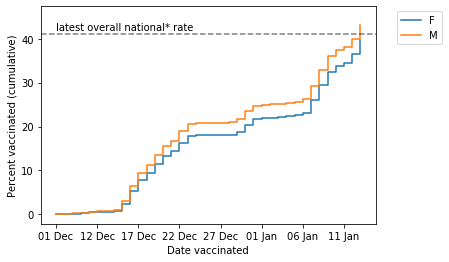

### COVID vaccinations among **80+** population by **Ethnicity broad categories**

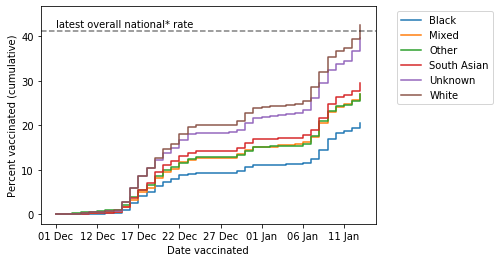

### COVID vaccinations among **80+** population by **Index of Multiple Deprivation**

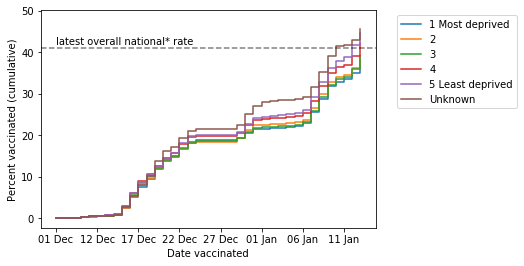

### COVID vaccinations among **80+** population by **bmi**

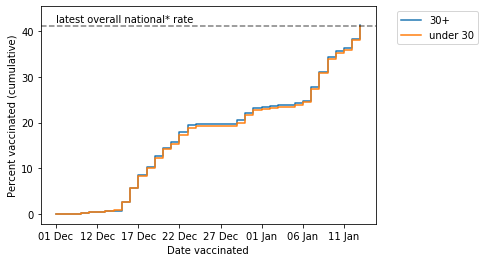

### COVID vaccinations among **80+** population by **chronic cardiac disease**

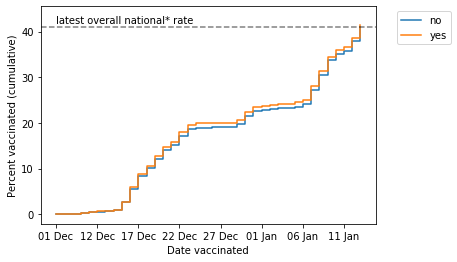

### COVID vaccinations among **80+** population by **current copd**

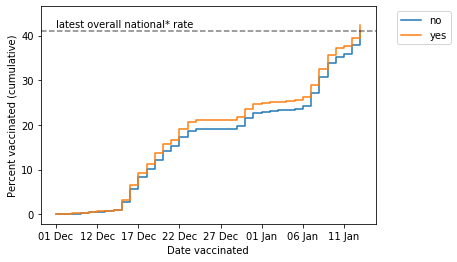

### COVID vaccinations among **80+** population by **dialysis**

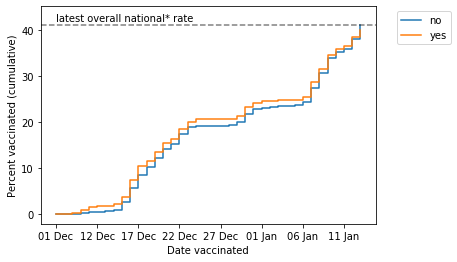

### COVID vaccinations among **80+** population by **dmards**

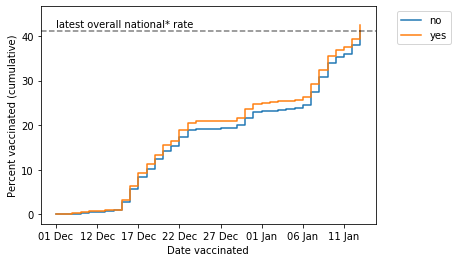

### COVID vaccinations among **80+** population by **psychosis schiz bipolar**

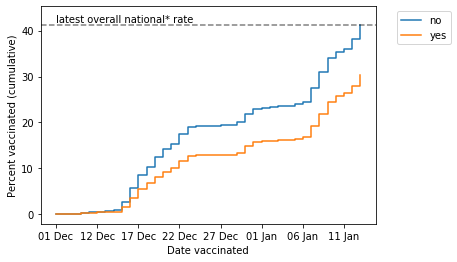

### COVID vaccinations among **80+** population by **intel dis incl downs syndrome**

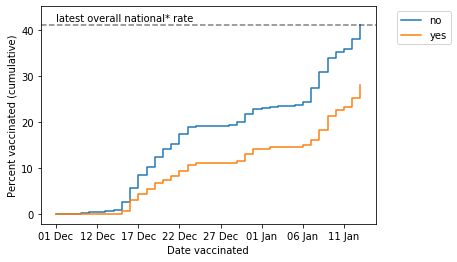

### COVID vaccinations among **80+** population by **dementia**

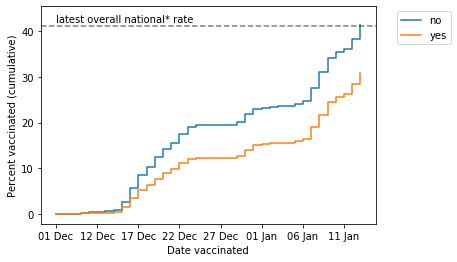

### COVID vaccinations among **80+** population by **ssri**

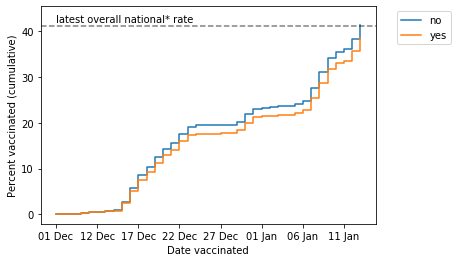

### COVID vaccinations among **80+** population by **chemo or radio**

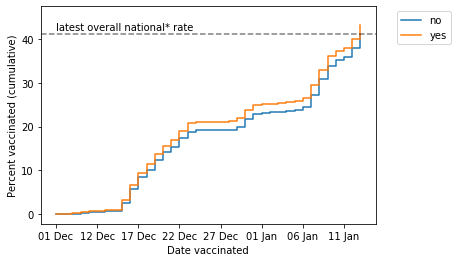

### COVID vaccinations among **80+** population by **lung cancer**

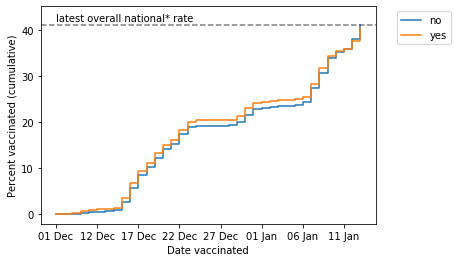

### COVID vaccinations among **80+** population by **cancer excl lung and haem**

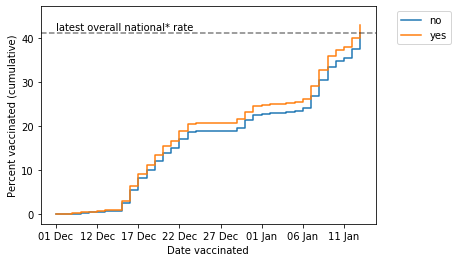

### COVID vaccinations among **80+** population by **haematological cancer**

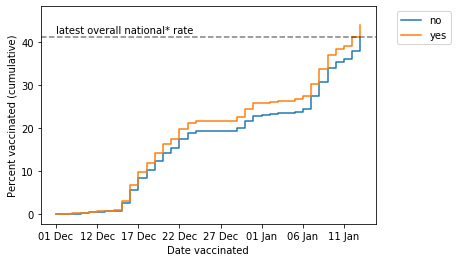

In [11]:
def plot_dem_charts(df_dict, include_overall=False):
    if include_overall==False:
        groups = ["sex","Ethnicity_broad_categories","Index_of_Multiple_Deprivation", "bmi", "chronic_cardiac_disease", "current_copd", "dialysis", "dmards",
                    "psychosis_schiz_bipolar","intel_dis_incl_downs_syndrome","dementia", "ssri",
                     "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"]
    else:
        groups = ["overall","sex","Ethnicity_broad_categories","Index_of_Multiple_Deprivation", "bmi", "chronic_cardiac_disease", "current_copd", "dialysis", "dmards",
                    "psychosis_schiz_bipolar","intel_dis_incl_downs_syndrome","dementia", "ssri",
                     "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"]
   
    for k in ["80+"]:
        display(Markdown(f"## COVID vaccination rollout among **{k}** population up to {latest_date_fmt}"))

        out=df_dict[k]
        for c in groups:
            out=df_dict[k][c]
            # suppress low numbers         
            cols = out.columns[(~out.columns.str.contains("_percent")) & (~out.columns.str.contains("_total"))]
            for c2 in cols:
                #  drop vaccinated and total column but keep percentage
                out = out.drop([c2, f"{c2}_total"],1)
                out = out.rename(columns={f"{c2}_percent":c2})

            display(Markdown(f"### COVID vaccinations among **{k}** population by **{c.replace('_',' ')}**"))
            out = out.reset_index()
            out["covid_vacc_date"] = pd.to_datetime(out["covid_vacc_date"]).dt.strftime("%d %b")
            out = out.set_index("covid_vacc_date")

            out.plot(legend=True, ds='steps-post')
            plt.axhline(overall_rate_80, color="k", linestyle="--", alpha=0.5)
            plt.text(0, overall_rate_80*1.02, "latest overall national* rate")
            plt.ylim(top=1.1*max(overall_rate_80, out.max().max()))
            plt.ylabel("Percent vaccinated (cumulative)")
            plt.xlabel("Date vaccinated")
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.show()
            
plot_dem_charts(df_dict_cum)

## Completeness of ethnicity recording

In [14]:
# overall among vaccinated people
vaccinated = df[["covid_vacc_date","community_ageband","Ethnicity_broad_categories","patient_id"]].loc[df["covid_vacc_date"]!=0]
vaccinated_ethnicity = vaccinated.groupby("Ethnicity_broad_categories")[["patient_id"]].nunique().reset_index()
out = vaccinated_ethnicity.loc[vaccinated_ethnicity["Ethnicity_broad_categories"]!="Unknown"]["patient_id"].sum()/\
    vaccinated_ethnicity["patient_id"].sum()

# in subgroups with denominators
for k in ["80+", "70-79","care home"]:
    out = df[["community_ageband","Ethnicity_broad_categories","patient_id","care_home"]].copy()
    out = out.loc[out[pops[k]]==k]
    
    total = out["patient_id"].nunique()
    
    known_eth = out.groupby("Ethnicity_broad_categories")[["patient_id"]].nunique().reset_index()
    known_eth = known_eth.loc[vaccinated_ethnicity["Ethnicity_broad_categories"]!="Unknown"]["patient_id"].sum()
    percent = round(100*(known_eth/total), 1)
    display(Markdown(f"Total **{k}** population with ethnicity recorded {known_eth:,d} ({percent}%)"))

    
other = df[["community_ageband","Ethnicity_broad_categories","patient_id"]].copy()
other = other.loc[~other["community_ageband"].isin(["care home","80+", "70-79"])]
vaccinated_ethnicity = vaccinated.groupby("Ethnicity_broad_categories")[["patient_id"]].nunique().reset_index()
out = vaccinated_ethnicity.loc[vaccinated_ethnicity["Ethnicity_broad_categories"]!="Unknown"]["patient_id"].sum()/\
    vaccinated_ethnicity["patient_id"].sum()
display(Markdown(f"Vaccinated **presumed healthcare workers (under 70, non-care home residents)** population with ethnicity recorded {other['patient_id'].nunique():,d} ({percent}%)"))


Total **80+** population with ethnicity recorded 834,423 (71.9%)

Total **70-79** population with ethnicity recorded 1,618,557 (77.8%)

Total **care home** population with ethnicity recorded 74,377 (76.7%)

Vaccinated **presumed healthcare workers (under 70, non-care home residents)** population with ethnicity recorded 386,913 (76.7%)